Importando as bibliotecas

In [18]:
import tensorflow as tf
import tensorflow.keras as keras
import sys
import matplotlib.pyplot as plt
import numpy as np

# **Dataset**

In [19]:
sys.path.append('..')

train_dir = '../data/train'
test_dir = '../data/test'

Optamos por setar um tamanho fixo de (64, 64) para diminuir o custo computacional de treinamento.

In [20]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(64, 64),
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(64, 64),
    batch_size=32,
    shuffle=True
)

num_classes = len(train_dataset.class_names)

Found 9979 files belonging to 10 classes.
Found 1267 files belonging to 10 classes.


## **Sobre os dados**

Escolhemos um dataset de classificação multiclasse sobre 10 espécies distintas de macacos:

In [21]:
print(train_dataset.class_names)

['bald_uakari', 'emperor_tamarin', 'golden_monkey', 'gray_langur', 'hamadryas_baboon', 'mandril', 'proboscis_monkey', 'red_howler', 'vervet_monkey', 'white_faced_saki']


### **Visualizando algumas amostras**

In [22]:
from random import randint
def choose_image(dataset, batch_size):
    idx = randint(0, batch_size-1)
    for images, labels in dataset.take(1):
        sample_image = images[idx].numpy().astype(int)
        sample_label = labels[idx].numpy()
        break
    return sample_image, sample_label

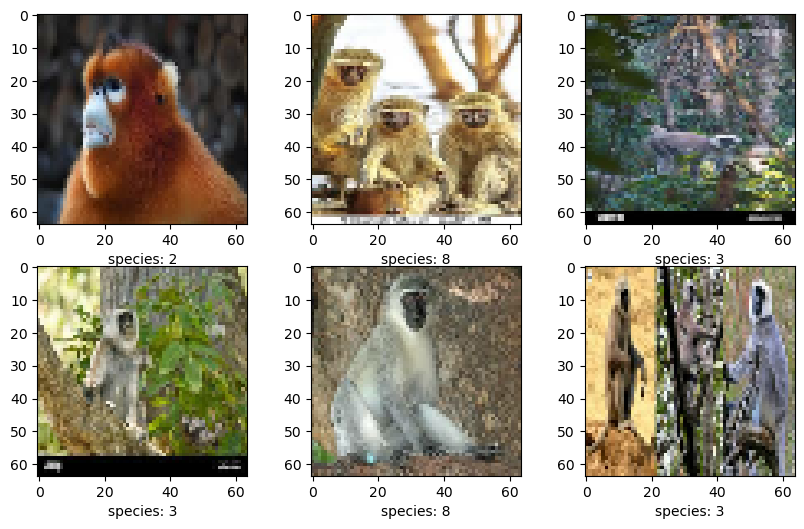

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

for i in range(2):
    for j in range(3):
        img, label = choose_image(train_dataset, 32)
        axs[i][j].imshow(img)
        axs[i][j].set_xlabel(f'species: {label}')

## **Pré-processamento do dataset**

### **Normalizando o dataset**

Assim, os valores ficam contidos em um intervalo entre 0 e 1, mais estável para o modelo.

In [24]:
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

### **Aplicando Data Augmentation**

Optamos por utilizar a técnica de Data Augmentation para generalizar melhor nosso modelo, e fugir de overfitting nos dados de treino.

Esse bloco sequencial fará parte do modelo na parte de treinamento, mas depois será ignorada na hora de predição.

In [25]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.1)
])

# **Modelo**

## **Arquitetura utilizada**

In [26]:
model = keras.Sequential([
    data_augmentation,
    
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

/home/diego/miniconda3/envs/general_ml/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Utilizamos o otimizador Adam, a função custo de Sparse Categorical CrossEntropy, e reportamos a métrica da acurácia a cada época.

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## **Treinamento**

### **Loop de treinamento**

In [28]:
EPOCHS = 100
history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS)

Epoch 1/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.2003 - loss: 2.1125 - val_accuracy: 0.5335 - val_loss: 1.3911
Epoch 2/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step - accuracy: 0.4524 - loss: 1.5802 - val_accuracy: 0.5320 - val_loss: 1.3450
Epoch 3/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - accuracy: 0.5159 - loss: 1.3937 - val_accuracy: 0.6227 - val_loss: 1.1163
Epoch 4/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step - accuracy: 0.5644 - loss: 1.2570 - val_accuracy: 0.5904 - val_loss: 1.1594
Epoch 5/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.6003 - loss: 1.1430 - val_accuracy: 0.6243 - val_loss: 1.1253
Epoch 6/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.6292 - loss: 1.0934 - val_accuracy: 0.6298 - val_loss: 1.0560
Epoch 7/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.6498 - loss: 1.0146 - val_accuracy: 0.6275 - val_loss: 1.0338
Epoch 8/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.6672 -

In [29]:
model.save('../models/trained_model.keras')

### **Gráfico da função custo**

Text(0, 0.5, 'Loss')

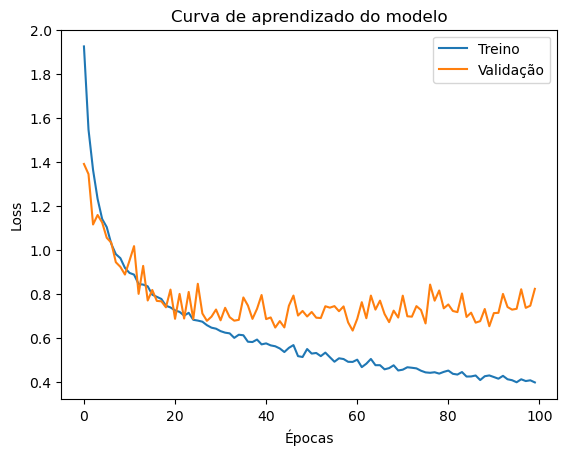

In [30]:
plt.title('Curva de aprendizado do modelo')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')
plt.ylabel('Loss')

## **Avaliação do modelo**

In [31]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model(images, training=False) 
    y_true.extend(labels.numpy()) 
    y_pred.extend(np.argmax(preds, axis=1))

2025-02-03 20:03:19.827233: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### **Acurácia**

In [33]:
print(f'Acurácia: {accuracy_score(y_pred, y_true):.2f}')

Acurácia: 0.78


### **Matriz de confusão**

In [34]:
cm = confusion_matrix(y_pred, y_true, normalize='true')
cm_display = ConfusionMatrixDisplay(cm)

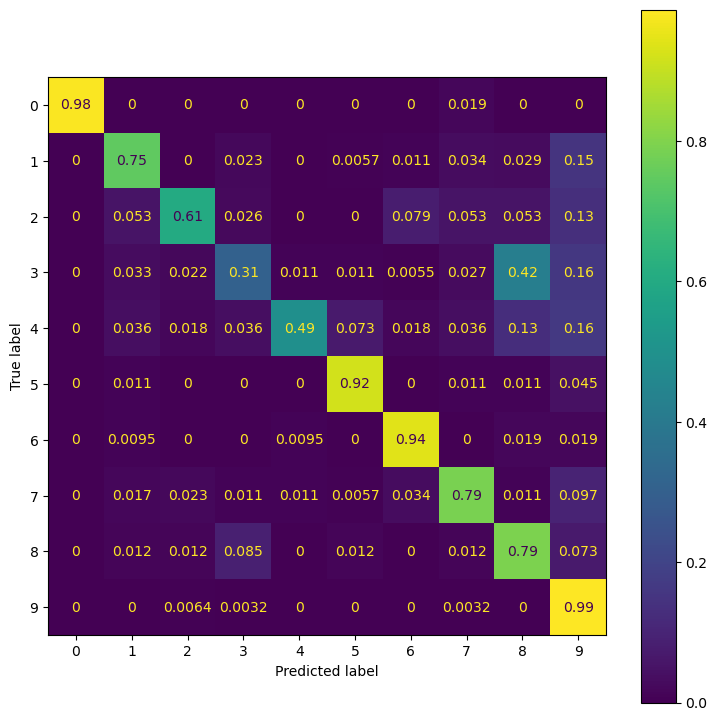

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
cm_display.plot(ax=ax)